In [1]:
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc
%matplotlib inline
%load_ext ipycache

%config InlineBackend.figure_format = 'svg'
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8

mpl.rcParams['font.family'] = ['Helvetica LT Std']
mpl.rcParams['font.sans-serif'] = ['Helvetica LT Std']
mpl.rcParams['text.usetex'] = False

mpl.rcParams['svg.fonttype'] = 'none'

/home/fabian/anaconda2/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/fabian/anaconda2/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
cell_numbers = pd.read_csv('../../data/cell_number_data.csv')
SOX2_numbers = cell_numbers[['ID', 'pos', 'time', 'SOX2']].dropna()

# Constant in space

Possibilities include 
* Bayesian inference using 2 zones which leads to no siginificant difference.
* fitting a line, should give gradient not different from 0
    * problem here is that sigma is unknown
* Test for normality (should give high GOF)



In [3]:
burn = 100000
iter_ = 1100000
thin = 1000

## Test two zones

In [4]:
def make_2zone_model(data, SOX2_min, SOX2_max, sigma_min, sigma_max):
    
    positions = sp.array(data['pos'])
    values_SOX2 = sp.array(data['SOX2'])
   
    def step_function(x, switchpoint, left_value, right_value):
        ''' This function should return something in the same format as the passed array 

          Specifically, it produces an output that has an array of the same size of the experimental data
        but whose contents are the lower average until the switchpoint, and the upper average past the switchpoint.
        For all purposes, this builds the model to which we want to compare the data.
        '''
        return sp.where(x<=switchpoint, left_value, right_value)
    
    SOX2_left_mean = pymc.Uniform('SOX2_left_mean', lower = SOX2_min, upper = SOX2_max, value = 30.0)
    SOX2_right_mean = pymc.Uniform('SOX2_right_mean', lower = SOX2_min, upper = SOX2_max, value = 30.0)
    switchpoint = pymc.Uniform('switchpoint', lower = positions.min(), upper = positions.max(),\
                               value = 0.5*(positions.max() - positions.min()) + positions.min())
    sigma = pymc.Uniform('sigma', lower = sigma_min, upper = sigma_max, value = 2.0)
    
    @pymc.deterministic(name='SOX2_step')
    def SOX2_step(SOX2_left_mean = SOX2_left_mean, SOX2_right_mean = SOX2_right_mean):
        return SOX2_left_mean - SOX2_right_mean
    
    @pymc.deterministic(name='SOX2_mean')
    def SOX2_mean(x = positions, switchpoint = switchpoint, left_value = SOX2_left_mean, right_value = SOX2_right_mean):
        return step_function(x, switchpoint, left_value, right_value)
    
    cells_SOX2 = pymc.Normal('cells_SOX2', mu=SOX2_mean, tau = 1/sigma**2, value = values_SOX2,\
                                           plot = False, observed = True)


    return locals()

In [5]:
SOX2_min, SOX2_max = 0.0, 50.0
sigma_min, sigma_max = 0.1, 10.0

In [6]:
%%cache step_df.pkl step_df --cachedir ../cache/density
%%time 
step_df = pd.DataFrame()
for ID, data in SOX2_numbers.set_index('ID').dropna().groupby(level = 'ID'):
    map_ = pymc.MAP(make_2zone_model(data, SOX2_min, SOX2_max, sigma_min, sigma_max))
    map_.fit()
    M = pymc.MCMC(map_)
    M.sample(iter=iter_, burn=burn, thin=thin, progress_bar=False)
#     pymc.Matplot.plot(M.SOX2_step)
    trace = M.SOX2_step.trace()
    step_df.loc[ID, 'mean'] = trace.mean()
    step_df.loc[ID, 'minus3sigma'] = sp.percentile(trace, 0.5*(100.0-99.73))
    step_df.loc[ID, 'plus3sigma'] = sp.percentile(trace, 100.0 - 0.5*(100.0-99.73))
    step_df.loc[ID, 'minus2sigma'] = sp.percentile(trace, 0.5*(100.0-95.4))
    step_df.loc[ID, 'plus2sigma'] = sp.percentile(trace, 100.0 - 0.5*(100.0-95.4))
    step_df.loc[ID, 'minus_p05'] = sp.percentile(trace, 0.5*(100.0-97.5))
    step_df.loc[ID, 'plus_p05'] = sp.percentile(trace, 100.0 - 0.5*(100.0-97.5))
    
    step_df.loc[ID, 'AICc'] = map_.AICc

[Skipped the cell's code and loaded variables step_df from file '/media/500G/fabian/work/axolotl/git/axolotl-spinal-cord-regeneration-mechanism/jupyter/calculations/cache/density/step_df.pkl'.]
CPU times: user 45min 24s, sys: 498 ms, total: 45min 24s
Wall time: 45min 25s


In [7]:
step_df.query('minus_p05 > 0 or plus_p05 < 0')

,mean,minus3sigma,plus3sigma,minus2sigma,plus2sigma,minus_p05,plus_p05,AICc
3D_2,-5.364232,-8.668578,-1.028550,-7.624516,-3.197330,-7.926537,-2.751976,114.161681
4D_1,-4.059149,-7.384591,3.645089,-6.392087,-1.764378,-6.648798,-1.140354,91.525845
6D_3,4.264154,-4.528040,9.842569,1.071891,7.161725,0.102304,7.520857,129.868231
8D_2,3.365180,1.032137,5.368513,2.068943,4.567468,1.907732,4.731656,75.398375


## Test for gradient

In [8]:
def make_line_model(data, m_min, m_max, n_min, n_max, sigma_min, sigma_max):
    
    positions = sp.array(data['pos'])
    values_SOX2 = sp.array(data['SOX2'])
   
    def line(x, m, n):
        return m * x + n
    
    m = pymc.Uniform('m', lower = m_min, upper = m_max, value = 0.0)
    n = pymc.Uniform('n', lower = n_min, upper = n_max, value = 30.0)
    sigma = pymc.Uniform('sigma', lower = sigma_min, upper = sigma_max, value = 2.0)
    
    @pymc.deterministic(name='SOX2_mean')
    def SOX2_mean(x = positions, m = m, n = n):
        return line(x, m, n)
    
    cells_SOX2 = pymc.Normal('cells_SOX2', mu=SOX2_mean, tau = 1/sigma**2, value = values_SOX2,\
                                           plot = False, observed = True)


    return locals()

In [9]:
m_min, m_max = -1.0, 1.0
n_min, n_max = 0.0, 50.0
sigma_min, sigma_max = 0.1, 10.0

In [10]:
%%cache m_df.pkl m_df --cachedir ../cache/density
%%time 
m_df = pd.DataFrame()
for ID, data in SOX2_numbers.set_index('ID').dropna().groupby(level = 'ID'):
    map_ = pymc.MAP(make_line_model(data, m_min, m_max, n_min, n_max, sigma_min, sigma_max))
    map_.fit()
    M = pymc.MCMC(map_)
    M.sample(iter=iter_, burn=burn, thin=thin, progress_bar=False)
#     pymc.Matplot.plot(M.m)
    trace =  M.m.trace()
    m_df.loc[ID, 'mean'] = trace.mean()
    m_df.loc[ID, 'minus3sigma'] = sp.percentile(trace, 0.5*(100.0-99.73))
    m_df.loc[ID, 'plus3sigma'] = sp.percentile(trace, 100.0 - 0.5*(100.0-99.73))
    m_df.loc[ID, 'minus2sigma'] = sp.percentile(trace, 0.5*(100.0-95.4))
    m_df.loc[ID, 'plus2sigma'] = sp.percentile(trace, 100.0 - 0.5*(100.0-95.4))
    m_df.loc[ID, 'minus_p05'] = sp.percentile(trace, 0.5*(100.0-97.5))
    m_df.loc[ID, 'plus_05'] = sp.percentile(trace, 100.0 - 0.5*(100.0-97.5))
    m_df.loc[ID, 'AICc'] = map_.AICc

[Skipped the cell's code and loaded variables m_df from file '/media/500G/fabian/work/axolotl/git/axolotl-spinal-cord-regeneration-mechanism/jupyter/calculations/cache/density/m_df.pkl'.]
CPU times: user 32min 47s, sys: 264 ms, total: 32min 48s
Wall time: 32min 48s


In [11]:
m_df.query('minus_p05 > 0 or plus_05 < 0')

,mean,minus3sigma,plus3sigma,minus2sigma,plus2sigma,minus_p05,plus_05,AICc
3D_2,0.003082,-0.000086,0.005812,0.001148,0.004983,0.000845,0.005202,102.516181
4D_1,0.003758,0.000025,0.007342,0.001590,0.005863,0.001431,0.006156,88.607768
6D_3,-0.002577,-0.006125,0.000447,-0.004652,-0.000501,-0.004852,-0.000129,129.590011
8D_2,-0.001640,-0.002793,-0.000639,-0.002370,-0.000994,-0.002463,-0.000838,71.062331


Calculate the relative change in density per milimeter

In [12]:
rel_dens_change = 1000 * sp.absolute(m_df.query('minus_p05 > 0 or plus_05 < 0')['mean']) / SOX2_numbers.set_index('ID')['SOX2'].groupby(level = 'ID').agg('mean')

In [13]:
rel_dens_change

0D_1         NaN
0D_2         NaN
0D_3         NaN
3D_1         NaN
3D_2    0.116215
3D_3         NaN
4D_1    0.126835
4D_2         NaN
4D_3         NaN
6D_1         NaN
6D_2         NaN
6D_3    0.086615
8D_1         NaN
8D_2    0.053330
8D_3         NaN
dtype: float64

## Constant

In [14]:
def make_constant_model(data, SOX2_min, SOX2_max, sigma_min, sigma_max):
    
    positions = sp.array(data['pos'])
    values_SOX2 = sp.array(data['SOX2'])
    
    SOX2_mean = pymc.Uniform('SOX2_mean', lower = SOX2_min, upper = SOX2_max, value = 30.0)
    sigma = pymc.Uniform('sigma', lower = sigma_min, upper = sigma_max, value = 2.0)
    
    cells_SOX2 = pymc.Normal('cells_SOX2', mu=SOX2_mean, tau = 1/sigma**2, value = values_SOX2,\
                                           plot = False, observed = True)

    return locals()

In [15]:
SOX2_min, SOX2_max = 0.0, 50.0
sigma_min, sigma_max = 0.1, 10.0

In [16]:
%%cache c_df.pkl c_df --cachedir ../cache/density
%%time 
c_df = pd.DataFrame()
for ID, data in SOX2_numbers.set_index('ID').dropna().groupby(level = 'ID'):
    map_ = pymc.MAP(make_constant_model(data, SOX2_min, SOX2_max, sigma_min, sigma_max))
    map_.fit()
    c_df.loc[ID, 'AICc'] = map_.AICc

[Skipped the cell's code and loaded variables c_df from file '/media/500G/fabian/work/axolotl/git/axolotl-spinal-cord-regeneration-mechanism/jupyter/calculations/cache/density/c_df.pkl'.]
CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 102 ms


## Compare AICc

The AICc of 2 zone model is probably wrong (switchpoint changes Likelihood only every 50 $\mu m$

In [17]:
AICc = pd.DataFrame()
AICc['constant'] = c_df['AICc']
AICc['line'] = m_df['AICc']
AICc['2zone'] = step_df['AICc']
AICc['constant<line'] = AICc['constant'] < AICc['line']
AICc

,constant,line,2zone,constant<line
0D_1,63.940639,66.128804,71.170584,True
0D_2,53.411980,56.899700,62.546050,True
0D_3,61.234091,60.684997,61.731990,False
3D_1,57.801557,60.509826,66.037929,True
3D_2,110.651018,102.516181,114.161681,False
3D_3,64.063458,67.121910,70.347189,True
4D_1,98.723801,88.607768,91.525845,False
4D_2,102.971748,102.056794,101.693386,False
4D_3,94.168577,92.991718,98.649776,False
6D_1,160.030241,159.422730,162.686205,False


## Normtest

In [18]:
pvalues = SOX2_numbers[['ID', 'SOX2']].groupby('ID').agg(lambda x: sp.stats.normaltest(x).pvalue)
pvalues

/home/fabian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1557: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
/home/fabian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1557: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/home/fabian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1557: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))
/home/fabian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1557: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/home/fabian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1557: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
/home/fabian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1557: UserWarning: kurtosist

,SOX2
ID,
0D_1,0.041457
0D_2,0.382492
0D_3,0.796721
3D_1,0.169890
3D_2,0.523419
3D_3,0.205621
4D_1,0.393315
4D_2,0.091583
4D_3,0.641776


Minimal p-Value = 0.041 -> no strong indication for non-Gaussuian distribution of density in space

# Constant in time

In [19]:
SOX2_space_mean = SOX2_numbers.groupby('ID').mean()

In [20]:
grouped = SOX2_space_mean.groupby('time')

In [21]:
samples = grouped.apply(lambda group: sp.array(group['SOX2'])).tolist()

In [22]:
sp.stats.f_oneway(*samples)

F_onewayResult(statistic=2.8942422926580331, pvalue=0.078743703075537991)

p-Value of 0.08 does not indicate significant difference between the samples from different time points.

In [23]:
SOX2_space_time_mean = grouped.agg(['mean', 'sem']).reset_index()

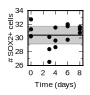

In [24]:
fig, ax = plt.subplots(figsize=(25.0 / 25.4, 25.0 / 25.4))
# plt.errorbar(sp.array(SOX2_space_time_mean['time']),\
#              sp.array(SOX2_space_time_mean['SOX2', 'mean']),\
#              sp.array(SOX2_space_time_mean['SOX2', 'sem']),\
#              fmt = 'o', color = 'black')
ax.scatter(SOX2_space_mean['time'], SOX2_space_mean['SOX2'], color = 'black', s = 10)
ax.plot([-0.5, 8.5], 2 * [SOX2_space_time_mean['SOX2', 'mean'].mean()], color = 'black')
ax.fill_between([-0.5, 8.5], 2 * [SOX2_space_time_mean['SOX2', 'mean'].mean() + SOX2_space_time_mean['SOX2', 'mean'].std()], 2 * [SOX2_space_time_mean['SOX2', 'mean'].mean() - SOX2_space_time_mean['SOX2', 'mean'].std()], alpha = 0.2, color = 'black', label = 'conf.belt')

ax.set_xlim(-0.5, 8.5)
ax.set_xlabel('Time (days)')
ax.set_ylabel('# SOX2+ cells')

ax.set_yticks(sp.arange(26, 35, 2))
ax.set_yticks(sp.arange(26, 35, 2)+1, minor = True)
ax.set_ylim(26, 34)

plt.savefig('../../figure_plots/Fig2_stem_cells_time.svg')
plt.show()

## Calculate mean density

In [25]:
Nsection = SOX2_space_time_mean['SOX2', 'mean'].mean()
Nsection

30.41564723044986

In [26]:
Nsection_sem = SOX2_space_time_mean['SOX2', 'mean'].sem()
Nsection_sem

0.57676964393245478

In [27]:
# see Rodrigo Albos et al., 2015
lcell = 13.2
lcell_sem = 0.1

In [28]:
rho = Nsection / lcell
rho

2.304215699276505

In [29]:
rho_ci = rho * (lcell_sem / lcell + Nsection_sem / Nsection)
rho_ci

0.061150849534856465